<a href="https://colab.research.google.com/github/isaacchunn/SC1015_MiniPrj_Airbnb/blob/main/Airbnb_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset : Airbnb Singapore Dataset from InsideAirbnb
#### Question : If we were an AirBnb host, how can we maximise our profit?


Dataset from Airbnb : **"Singapore, 29 December 2022"**  
Source: http://insideairbnb.com/get-the-data/


# Contents
  1. KMeans
  2. Random Forest

---

### Essential Libraries

Import essential libraries such as numpy, pandas, matplotlib and seaborn.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [56]:
# Isaac Chun Jun Heng U2221389B
# J'sen Ong Jia Xuan  U2220457J
# Tang Teck Meng U2221809C

In [57]:
#Basic libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt #We only need pyplot
sb.set() #Set the default Seaborn style for graphics

### Additional Libraries

Import additional libraries

> sklearn : Conduct linear regression analysis

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### General Utility Functions

In [59]:
def countOutliers (df):
    #Get the q1 and q3 datas to find out the 25% and 75% range, then calculate inter quartile range and then find out whiskers.
    #Then count how many points lie outside of this range.
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    #Interquartile
    iqr = q3 - q1
    #Calculate whiskers
    leftWhisker = q1 - (1.5 * iqr)
    rightWhisker = q3 + (1.5 * iqr)
    outliers = 0;
    #Loop through data now
    for data in df:
        if(data < leftWhisker or data > rightWhisker):
            outliers+=1

    return outliers

In [60]:
def removeOutliers(df, colName):
  q1 = df[colName].quantile(0.25)
  q3 = df[colName].quantile(0.75)
  iqr = q3-q1
  low = q1 - 1.5 * iqr
  high = q3 + 1.5 * iqr
  result = df.loc[(df[colName] >= low) & (df[colName] <= high)]
  return result

In [61]:
def remove_outliers(df, columns, factor=1.5):
    # loop through each column and remove outliers based on the IQR method
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + factor * iqr
        lower_bound = q1 - factor * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

### Mount Google Drive (unused, uncomment if need add anything from google drive.)

In [62]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

---

>## Hypothesis  

1. The amenities a listing provides will affect its price, the more the amenities, the higher the listing price
2. Variables related to a listing's review will have positive correlation to listing's price
3. The property type of a listing will have positive correlation to listing price.

---

>## Import the Dataset  

We have imported the cleaned dataset based on our EDA done in the other files.

In [63]:
url = "https://raw.githubusercontent.com/isaacchunn/SC1015_MiniPrj_Airbnb/main/listings_cleaned.csv"
airDF = pd.read_csv(url)
airDF.head()

,name,listing_url,description,neighborhood_overview,host_response_time,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable
0,Ensuite Room (Room 1 & 2) near EXPO,https://www.airbnb.com/rooms/71609,For 3 rooms.Book room 1&2 and room 4<br /><br ...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34537,...,20.0,4.44,4.37,4.00,4.63,4.78,4.26,4.32,NaN,f
1,B&B Room 1 near Airport & EXPO,https://www.airbnb.com/rooms/71896,<b>The space</b><br />Vocational Stay Deluxe B...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34754,...,24.0,4.16,4.22,4.09,4.43,4.43,4.17,4.04,NaN,t
2,Room 2-near Airport & EXPO,https://www.airbnb.com/rooms/71903,"Like your own home, 24hrs access.<br /><br /><...",Quiet and view of the playground with exercise...,within a few hours,90%,100%,Tampines,East Region,1.34531,...,47.0,4.41,4.39,4.52,4.63,4.64,4.50,4.36,NaN,f
3,Amazing Room with window 10min to Redhill,https://www.airbnb.com/rooms/275343,Awesome location and host <br />Room near INSE...,NaN,within an hour,100%,85%,Bukit Merah,Central Region,1.29015,...,22.0,4.40,4.16,4.26,4.47,4.42,4.53,4.63,S0399,f
4,15 mins to Outram MRT Single Room,https://www.airbnb.com/rooms/275344,Lovely home for the special guest !<br /><br /...,Bus stop <br />Food center <br />Supermarket,within an hour,100%,85%,Bukit Merah,Central Region,1.28836,...,14.0,4.50,4.69,4.23,4.62,4.54,4.62,4.46,S0399,f


In [64]:
airDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          3035 non-null   object 
 1   listing_url                   3035 non-null   object 
 2   description                   2968 non-null   object 
 3   neighborhood_overview         1968 non-null   object 
 4   host_response_time            2405 non-null   object 
 5   host_response_rate            2405 non-null   object 
 6   host_acceptance_rate          2284 non-null   object 
 7   neighbourhood_cleansed        3018 non-null   object 
 8   neighbourhood_group_cleansed  3018 non-null   object 
 9   latitude                      3018 non-null   float64
 10  longitude                     3018 non-null   float64
 11  property_type                 3018 non-null   object 
 12  accommodates                  3018 non-null   float64
 13  ame

In [65]:
print(airDF.dtypes)

name                             object
listing_url                      object
description                      object
neighborhood_overview            object
host_response_time               object
host_response_rate               object
host_acceptance_rate             object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
accommodates                    float64
amenities                        object
price                            object
minimum_nights                  float64
maximum_nights                  float64
number_of_reviews               float64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64


---

>## Cleaning our DataFrame/Dataset

### 1. Drop properties with N/A or 0% acceptance rate as these properties do not get stayed at by visitors.

In [66]:
#Drop all the properties that has no host acceptance rate then drop
airDF = airDF.dropna(subset=["host_acceptance_rate"])
#Then remove all the 0% acceptance rate
airDF = airDF[airDF["host_acceptance_rate"] != 0]
#Resort our indexes
airDF = airDF.reset_index(drop=True)
airDF.head(n=5)

,name,listing_url,description,neighborhood_overview,host_response_time,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable
0,Ensuite Room (Room 1 & 2) near EXPO,https://www.airbnb.com/rooms/71609,For 3 rooms.Book room 1&2 and room 4<br /><br ...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34537,...,20.0,4.44,4.37,4.00,4.63,4.78,4.26,4.32,NaN,f
1,B&B Room 1 near Airport & EXPO,https://www.airbnb.com/rooms/71896,<b>The space</b><br />Vocational Stay Deluxe B...,NaN,within a few hours,90%,100%,Tampines,East Region,1.34754,...,24.0,4.16,4.22,4.09,4.43,4.43,4.17,4.04,NaN,t
2,Room 2-near Airport & EXPO,https://www.airbnb.com/rooms/71903,"Like your own home, 24hrs access.<br /><br /><...",Quiet and view of the playground with exercise...,within a few hours,90%,100%,Tampines,East Region,1.34531,...,47.0,4.41,4.39,4.52,4.63,4.64,4.50,4.36,NaN,f
3,Amazing Room with window 10min to Redhill,https://www.airbnb.com/rooms/275343,Awesome location and host <br />Room near INSE...,NaN,within an hour,100%,85%,Bukit Merah,Central Region,1.29015,...,22.0,4.40,4.16,4.26,4.47,4.42,4.53,4.63,S0399,f
4,15 mins to Outram MRT Single Room,https://www.airbnb.com/rooms/275344,Lovely home for the special guest !<br /><br /...,Bus stop <br />Food center <br />Supermarket,within an hour,100%,85%,Bukit Merah,Central Region,1.28836,...,14.0,4.50,4.69,4.23,4.62,4.54,4.62,4.46,S0399,f


### 2. Clean the price column using code as it has "$", "," and "." 


In [67]:
airDF["price"]

0       $46,437.00 
1           $81.00 
2           $81.00 
3           $52.00 
4           $49.00 
           ...     
2279        $45.00 
2280        $45.00 
2281       $186.00 
2282       $797.00 
2283       $434.00 
Name: price, Length: 2284, dtype: object

In [68]:
breaks = [",", "$"]
for i in range(len(airDF["price"])):
    s = airDF.loc[:,("price")][i]
    for x in breaks:
        s = s.replace(x,"")
    s = "".join(s.split(".")[:-1])
    airDF.loc[:,("price")][i] = int(s)
airDF = airDF.astype({'price': 'int32'})

<ipython-input-68-e0f04e7ead66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF.loc[:,("price")][i] = int(s)


We also remove any outliers as it is unrealistic for a property to have above > $45,000 per night

In [69]:
airDF = remove_outliers(airDF, ["price"])
#airDF = airDF[airDF.price < 350]
#Resort our indexes
airDF = airDF.reset_index(drop=True)
airDF["price"]

0        81
1        81
2        52
3        49
4       175
       ... 
2103     45
2104     45
2105     45
2106    186
2107    434
Name: price, Length: 2108, dtype: int32

### 3. Convert the amenities column to a list, and add a new column with the number of amenities to be used for our prediction.

In [70]:
airDF["amenities"]

0       ["Cooking basics", "Refrigerator", "Kitchen", ...
1       ["Cooking basics", "Heating", "Kitchen", "Hair...
2       ["Air conditioning", "Shampoo", "Smoke alarm",...
3       ["Air conditioning", "Shampoo", "Smoke alarm",...
4       ["Cooking basics", "Kitchen", "Private entranc...
                              ...                        
2103    ["Air conditioning", "Fire extinguisher", "Sec...
2104    ["Air conditioning", "Fire extinguisher", "Sec...
2105    ["Air conditioning", "Fire extinguisher", "Sec...
2106    ["Air conditioning", "Fire extinguisher", "Sec...
2107    ["Air conditioning", "Fire extinguisher", "Fir...
Name: amenities, Length: 2108, dtype: object

In [71]:
#Add a new column of amenities
airDF["no_amenities"] = 0
#Replace all with the integer variant
count = 0
for x in airDF["amenities"]:   
    #Convert string into list
    #Convert string into list
    x = x.replace('[',"")
    x = x.replace(']',"")
    x = x.replace('"', "")
    x = x.replace(", ", ",")
    x = x.split(",")
    airDF["amenities"][count] = x
    airDF["no_amenities"][count] = len(x)
    count += 1

<ipython-input-71-a56617251945>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["amenities"][count] = x
<ipython-input-71-a56617251945>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["no_amenities"][count] = len(x)


In [72]:
airDF["amenities"].head(n=5)

0    [Cooking basics, Refrigerator, Kitchen, Hair d...
1    [Cooking basics, Heating, Kitchen, Hair dryer,...
2    [Air conditioning, Shampoo, Smoke alarm, Long ...
3    [Air conditioning, Shampoo, Smoke alarm, Long ...
4    [Cooking basics, Kitchen, Private entrance, Ha...
Name: amenities, dtype: object

In [73]:
airDF["no_amenities"].head(n=5)

0    31
1    26
2    17
3    18
4    32
Name: no_amenities, dtype: int64

In [74]:
#Want to visualize the total count of amenities so we can form a generalization such that our number of amenities remains reliable.
amenityCount = {}
for x in airDF["amenities"]:
    for item in x:
        if item in amenityCount:
            amenityCount[item] += 1
        else:
            amenityCount[item] = 1
        
#Add it to a DF
amenityCountDF = pd.DataFrame(columns = ["amenity", "count"])
count = 0
for keys, values in amenityCount.items():
    amenityCountDF.loc[count] = [keys, values]
    count += 1

#Sort the DF
amenityCountDF = amenityCountDF.sort_values(by="count", ascending = False)
amenityCountDF.head(n=15)

,amenity,count
9,Long term stays allowed,2100
7,Wifi,2047
32,Air conditioning,1945
17,Essentials,1804
2,Kitchen,1728
43,Hangers,1664
30,Washer,1611
39,Iron,1603
26,Hot water,1495
3,Hair dryer,1404


In [75]:
amenityCountDF.tail(n=10)

,amenity,count
273,Kitchenette,1
272,24-hour fitness center,1
271,Backyard - Not fully fenced,1
269,HDTV with standard cable,1
105,Sunsilk conditioner,1
264,Private outdoor pool - olympic-sized,1
184,Stainless steel electric stove,1
87,43\ HDTV with Disney+,1
261,BBQ grill: electric,1
252,43\ HDTV with Amazon Prime Video,1


We have decided to only use those amenities that are very prominent in most of the listings as the number of amenities should be consistent, and not be filled with many values that do not matter. For example, we do not know what Fire TV is.

In [76]:
#Changeable cutoff that are determined by us to check for robustness of our model
amenityCutOff = 30

In [77]:
uselessAmenityList = amenityCountDF[amenityCountDF["count"] <= amenityCutOff]["amenity"].values.tolist()

In [78]:
#Remove all values in our df that correspond to our useless amenity list
count = 0
for x in airDF["amenities"]:
    l = [i for i in x if i not in uselessAmenityList]
    airDF["amenities"][count] = l
    airDF["no_amenities"][count] = len(l)
    count +=1

<ipython-input-78-ae78827c68ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["amenities"][count] = l
<ipython-input-78-ae78827c68ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airDF["no_amenities"][count] = len(l)


### 4. Fill in na values in host_response_time to be a value as we are using it to gather insights

In [79]:
print("Null values:", airDF["host_response_time"].isnull().sum().sum())

Null values: 91


In [80]:
airDF["host_response_time"].value_counts()

within an hour        774
within a few hours    690
within a day          444
a few days or more    109
Name: host_response_time, dtype: int64

In [81]:
#Fill it to be the worst scenario to achieve better distribution
airDF = airDF.fillna(value = {"host_response_time": "a few days or more"})
None

In [82]:
print("Null values:", airDF["host_response_time"].isnull().sum().sum())

Null values: 0


In [83]:
airDF["host_response_time"].value_counts()

within an hour        774
within a few hours    690
within a day          444
a few days or more    200
Name: host_response_time, dtype: int64

---

>## Splitting the Dataset

In [84]:
#Split the dataset into train and test in 80:20 ratio
train_data, test_data = train_test_split(airDF, test_size = 0.2, random_state = 55)

#Print out what we have in our test and train data
print("Train Data :")
print("Data type : ", type(train_data))
print("Data dim : ", train_data.shape)
print("---------------------------------------")
print("Test Data :")
print("Data type : ", type(test_data))
print("Data dim : ", test_data.shape)
print("---------------------------------------")

Train Data :
Data type :  <class 'pandas.core.frame.DataFrame'>
Data dim :  (1686, 28)
---------------------------------------
Test Data :
Data type :  <class 'pandas.core.frame.DataFrame'>
Data dim :  (422, 28)
---------------------------------------


---
##One - hot encoding all the potential categorical variables !


In [85]:
#lets clean amenities first
new_DF = pd.DataFrame(airDF)
testDF = pd.DataFrame(airDF["amenities"]).astype(str)

#Use a set as it prevents duplicate
uniqueNames = set()
for idx in range(0, len(testDF["amenities"])):
  #Test split on first and making data frame for scaling later
  s = testDF["amenities"][idx]
  #Replace the apostrophes
  s = s.replace("'", "")
  #Replace the [ and ]
  s = s.replace("[", "")
  s = s.replace("]", "")
  s = s.replace(", ", ",")
  wordList = s.split(",")
  #Update the string at this index
  testDF["amenities"].iloc[idx] = wordList;

  #Add each word into the set
  for x in wordList:
    uniqueNames.add(x)

#Then create our new pd with our set
amenitiesDF = pd.DataFrame(np.empty((len(testDF), len(uniqueNames))) * np.nan ,columns = list(uniqueNames))
#Loop through the current df 
for idx in range(0, len(testDF["amenities"])):
  words = testDF["amenities"][idx]
  #Loop through each amenity, and then update our adj matrix
  for word in words:
    amenitiesDF[word][idx] = 1

amenitiesDF = amenitiesDF.fillna(0)
amenitiesDF

,Lock on bedroom door,Crib - available upon request,Security cameras on property,open specific hours,Stove,Sound system,Pack \\u2019n play/Travel crib,Smoke alarm,Gym,Bidet,...,Backyard,Laundromat nearby,Microwave,Heating,Shower gel,Safe,Central air conditioning,Cleaning available during stay,Free street parking,Hot water
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2105,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
numerical_variables = ["accommodates", "no_amenities"]
cat_variables = ['host_response_time', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type']
potential_variables = list(cat_variables + numerical_variables)
potential_variables

['host_response_time',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'accommodates',
 'no_amenities']

In [87]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

#we will exclude amenities since that feature requires individual data cleaning
potentialFeaturesDF = pd.DataFrame(airDF[potential_variables])
#airbnb_cat = pd.concat([potentialFeaturesDF[cat_variables],amenitiesDF])
airbnb_cat = potentialFeaturesDF[cat_variables]
#OHE airbnb_cat categorical predictors
ohe.fit(airbnb_cat)
airbnb_cat_ohe = pd.DataFrame(ohe.transform(airbnb_cat).toarray(),
                             columns=ohe.get_feature_names_out(airbnb_cat.columns))

airbnb_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2108 entries, 0 to 2107
Data columns (total 86 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   host_response_time_a few days or more             2108 non-null   float64
 1   host_response_time_within a day                   2108 non-null   float64
 2   host_response_time_within a few hours             2108 non-null   float64
 3   host_response_time_within an hour                 2108 non-null   float64
 4   neighbourhood_cleansed_Ang Mo Kio                 2108 non-null   float64
 5   neighbourhood_cleansed_Bedok                      2108 non-null   float64
 6   neighbourhood_cleansed_Bishan                     2108 non-null   float64
 7   neighbourhood_cleansed_Bukit Batok                2108 non-null   float64
 8   neighbourhood_cleansed_Bukit Merah                2108 non-null   float64
 9   neighbourhood_clean

In [88]:
# Combining Numeric features with the OHE Categorical features
airbnb_num = potentialFeaturesDF[numerical_variables]
airbnbData_ohe = pd.concat([airbnb_num , airbnb_cat_ohe],sort=False,axis=1).reindex(index=airbnb_num.index)

# Check the final dataframe
airbnbData_ohe

,accommodates,no_amenities,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,...,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in condo,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in serviced apartment
0,1.0,28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,17,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,1.0,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2104,1.0,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2105,1.0,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2106,4.0,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

>## 1. Multi-variate K Means

In [119]:
priceDF = airDF["price"]
priceDF.head(n=5)

0     81
1     81
2     52
3     49
4    175
Name: price, dtype: int32

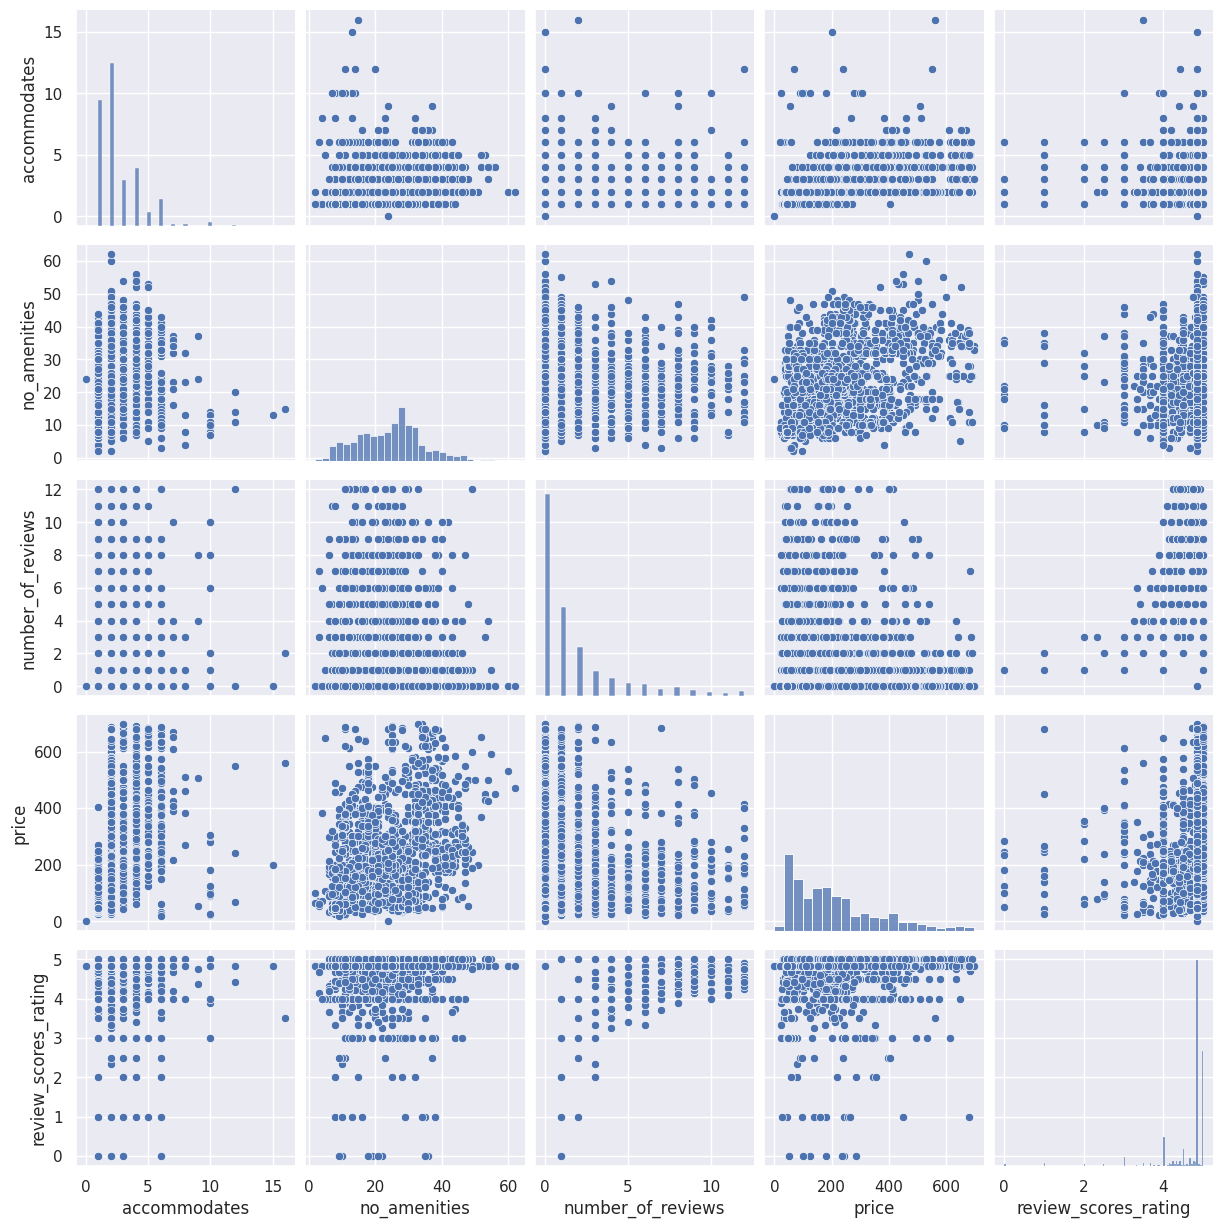

In [127]:
#Input the numerical values we had identified beforehand
kmeansDF = airDF[["accommodates","no_amenities","number_of_reviews", "price", "review_scores_rating"]].copy()
kmeansDF = remove_outliers(kmeansDF, ["number_of_reviews"])
# filling in null values with median
kmeansDF.fillna(kmeansDF.median(), inplace = True)

#Plot its data on 2d grids
sb.pairplot(kmeansDF)

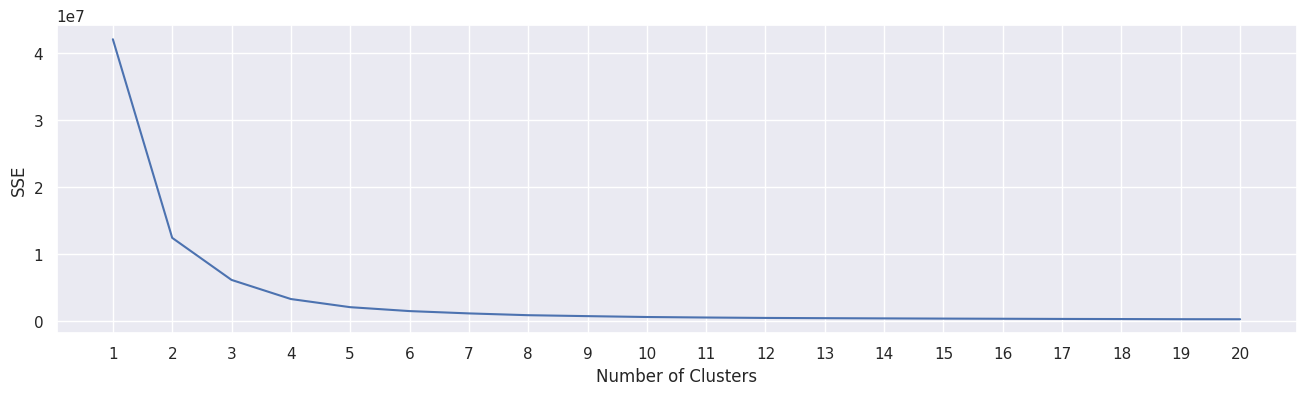

In [128]:
# Import kmeans model from sklearn
from sklearn.cluster import KMeans

#Vary the number of clusters
minClusterRange = 1
maxClusterRange = 20

#We want to use the elbow method, so we will compute all sse for each "k" and store into our sse list 
#"k-means++" employs an advanced trick to speed up convergence
sse = [] 
for k in range(minClusterRange, maxClusterRange + 1):
  kmeans = KMeans(n_clusters = k, init = "k-means++", n_init= 10)
  kmeans.fit(kmeansDF)
  sse.append(kmeans.inertia_)

#Plot the SSE curve to find our elbow point
f = plt.figure(figsize=(16,4))
plt.plot(range(minClusterRange, maxClusterRange+1), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(np.arange(minClusterRange, maxClusterRange+1, step = 1))
plt.show()
None

It seems from this that our elbow point is either 2 or 3 as our best k. Let us use another technique called silhouette coefficient to find out the best k

In [129]:
from sklearn.metrics.cluster import silhouette_score
silhouette_coefficients = []
minClusterRange = 2 #Start at 2 for silhouette coefficient
maxClusterRange = 20

for k in range(minClusterRange, maxClusterRange +1):
  kmeans = KMeans(n_clusters = k, init= "k-means++", n_init = 10)
  kmeans.fit(kmeansDF)
  score = silhouette_score(kmeansDF, kmeans.labels_)
  silhouette_coefficients.append(score)

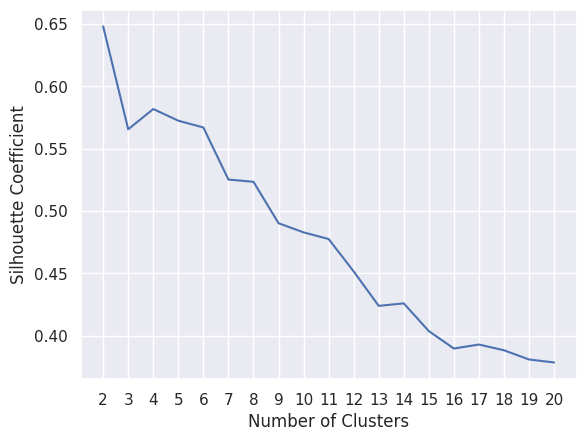

In [130]:
#Plot out what we have found based on our silhouette coefficients
plt.plot(range(minClusterRange, maxClusterRange + 1), silhouette_coefficients)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks(np.arange(minClusterRange, maxClusterRange+1, step = 1))
plt.show()

From this, let us try 4 as it is an optimal score for now

In [132]:
k = 4

#Use our kmeans with our newly found k
kmeans = KMeans(n_clusters = k,         
               init = "k-means++",
               n_init = 10)                 

#Fit the kmeans onto our DF
kmeans.fit(kmeansDF)
#Then call predict 
kmeansPrediction = kmeans.predict(kmeansDF)
None

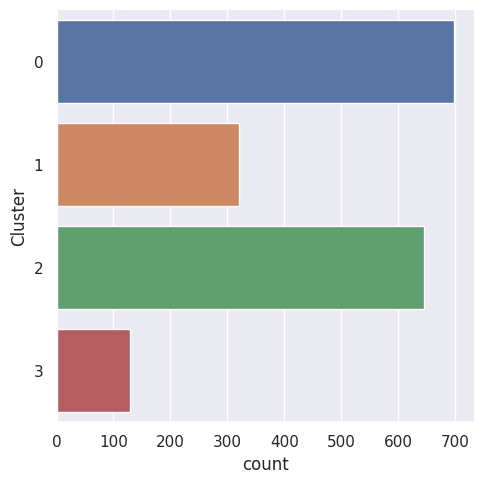

In [133]:
kmeans_labeled = kmeansDF.copy()
kmeans_labeled["Cluster"] = pd.Categorical(kmeansPrediction)

# Catplot the counts in our cluters
sb.catplot(y = "Cluster", data = kmeans_labeled, kind = "count")

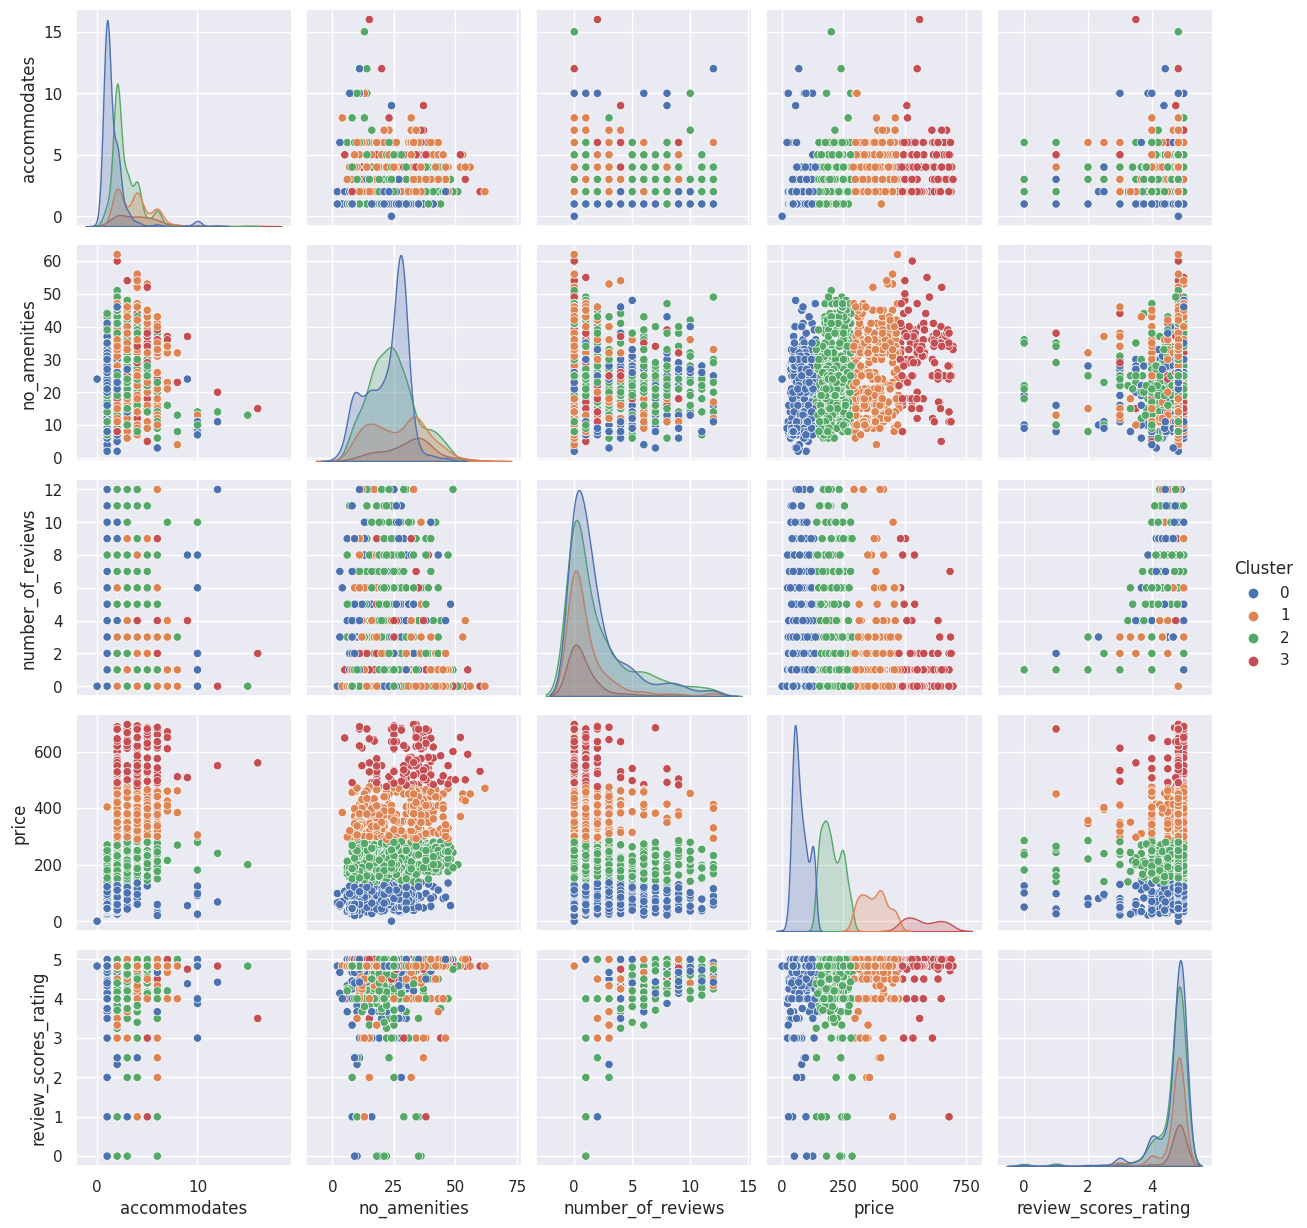

In [134]:
#Plot all our clusters on 2d grids using cluster column
sb.pairplot(kmeans_labeled, vars = kmeansDF.columns.values, hue = "Cluster")

<Axes: xlabel='price', ylabel='Cluster'>

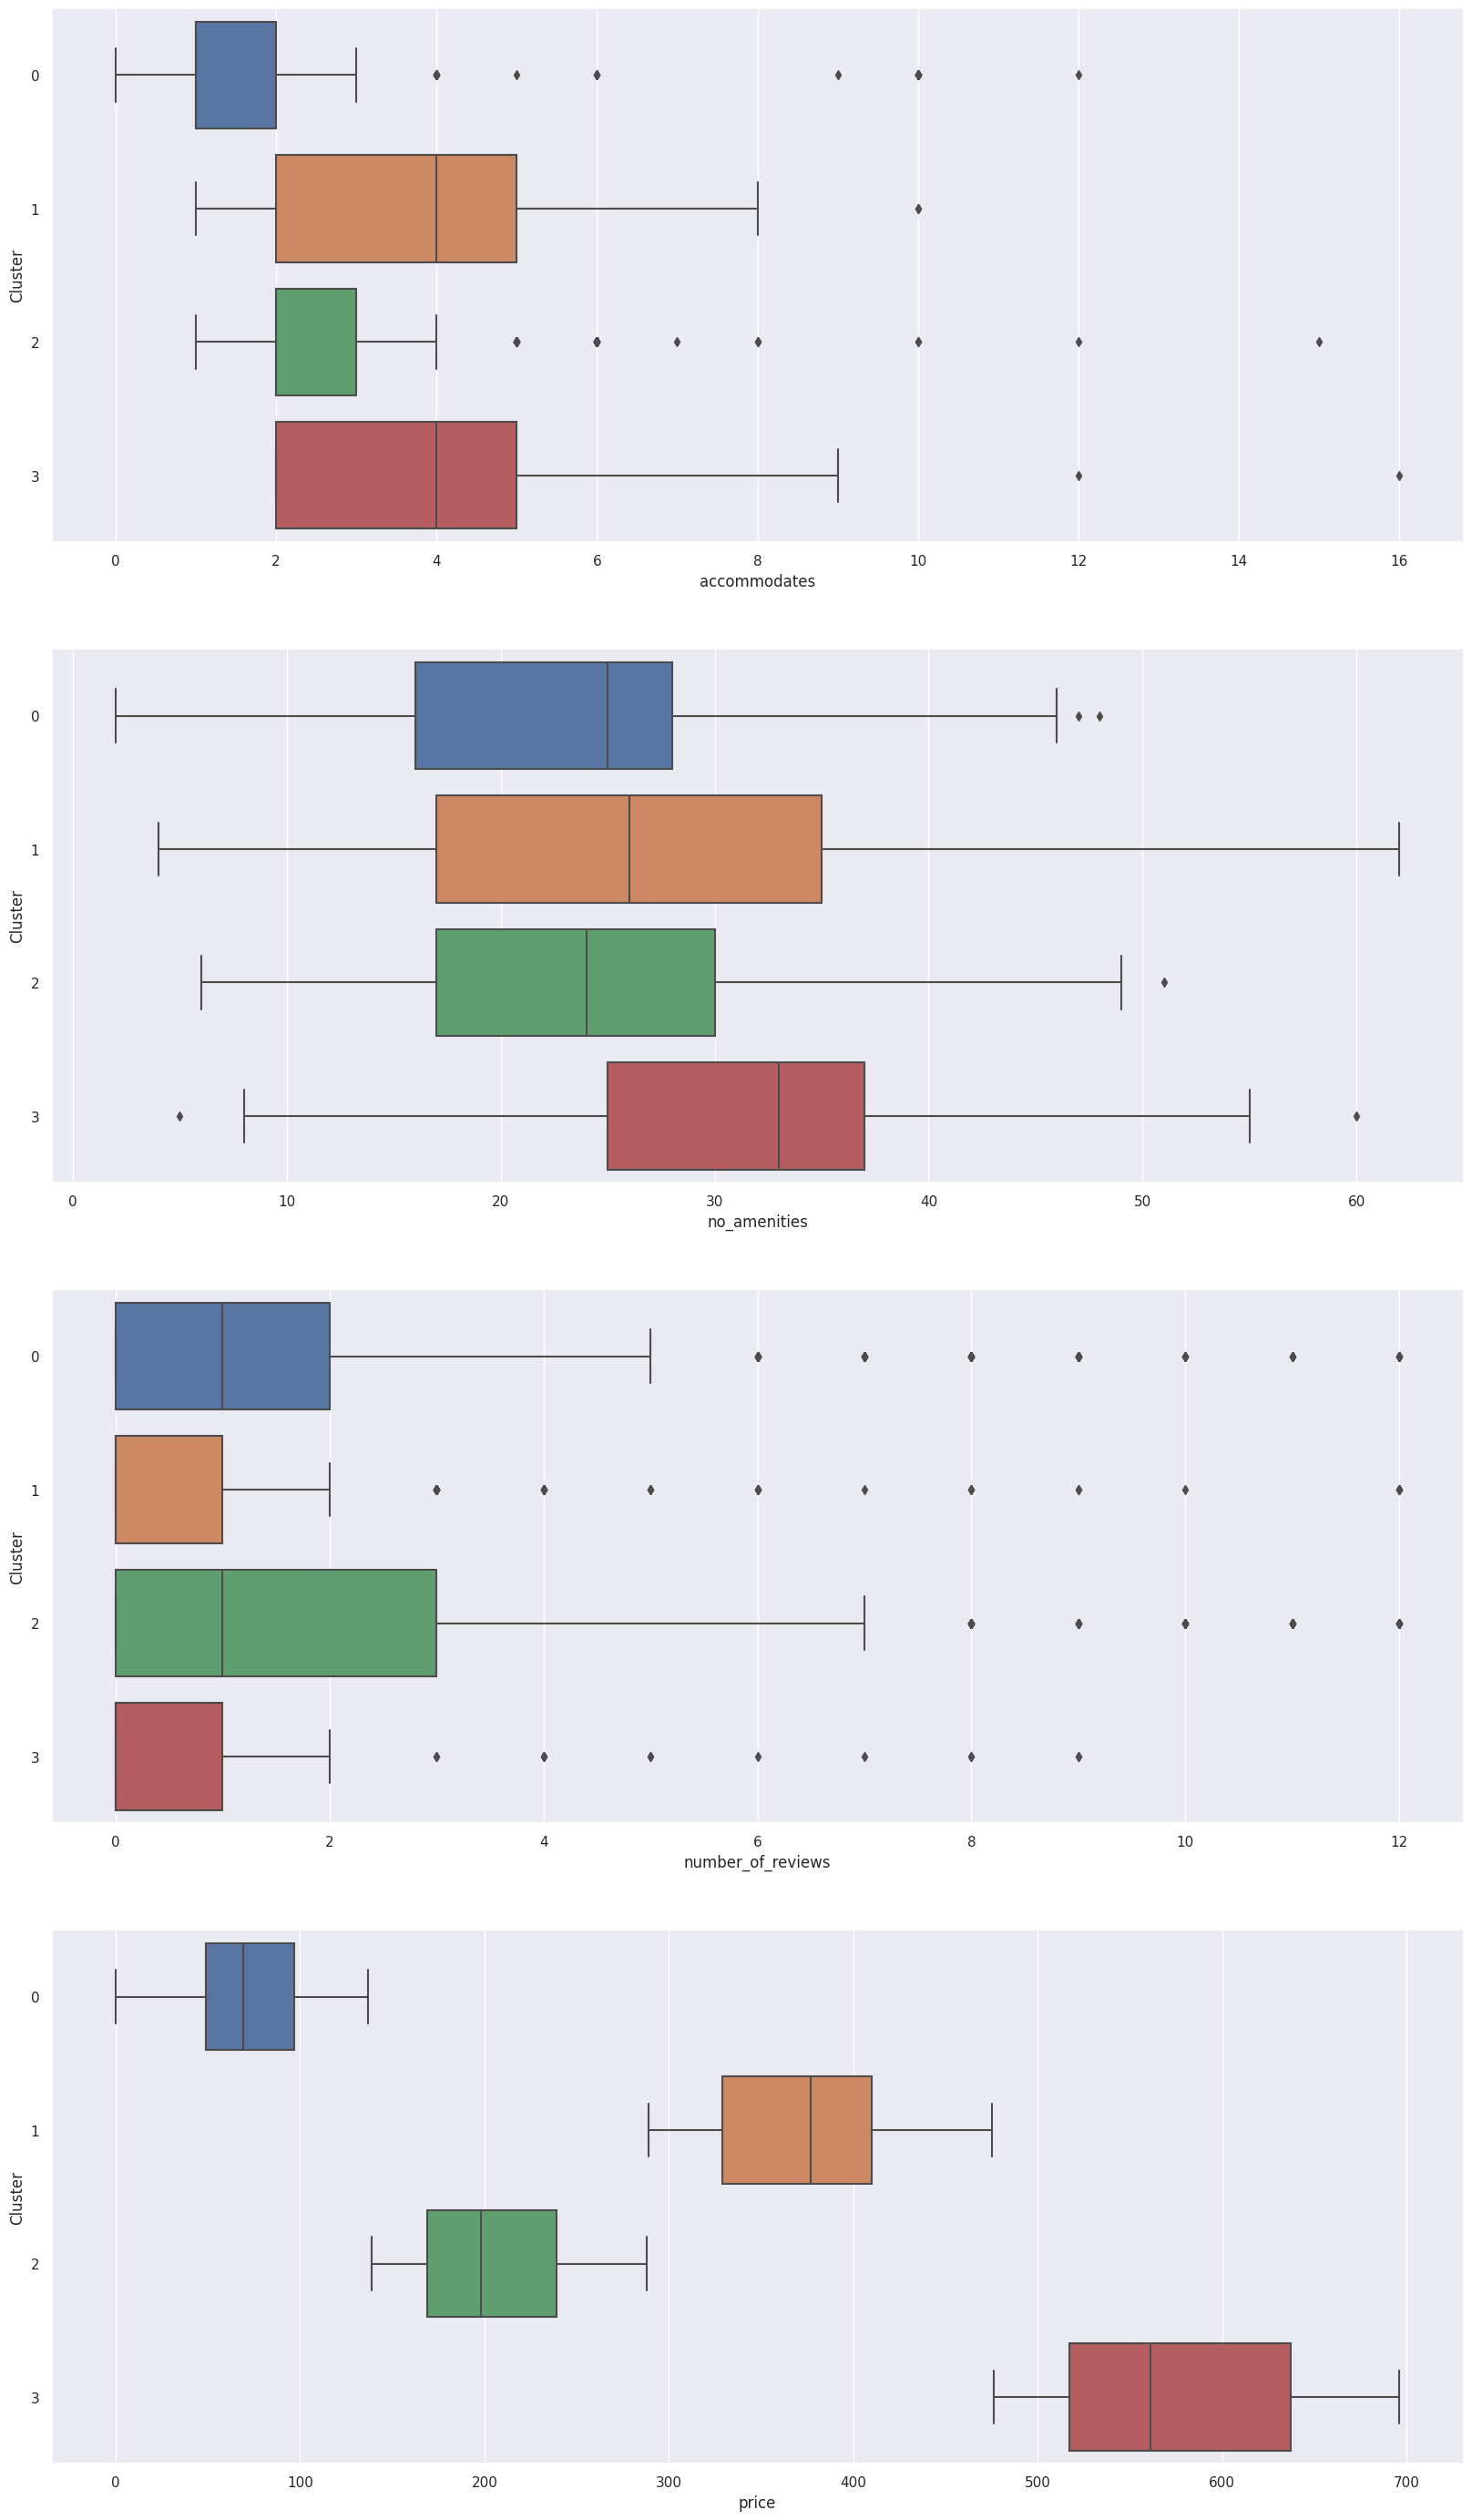

In [135]:
# Boxplots for all Features against the Clusters
f, axes = plt.subplots(4, 1, figsize=(20,35))
sb.boxplot(x = 'accommodates', y = 'Cluster', data = kmeans_labeled, ax = axes[0])
sb.boxplot(x = 'no_amenities', y = 'Cluster', data = kmeans_labeled, ax = axes[1])
sb.boxplot(x = 'number_of_reviews', y = 'Cluster', data = kmeans_labeled, ax = axes[2])
sb.boxplot(x = 'price', y = 'Cluster', data = kmeans_labeled, ax = axes[3])

<Axes: xlabel='Cluster'>

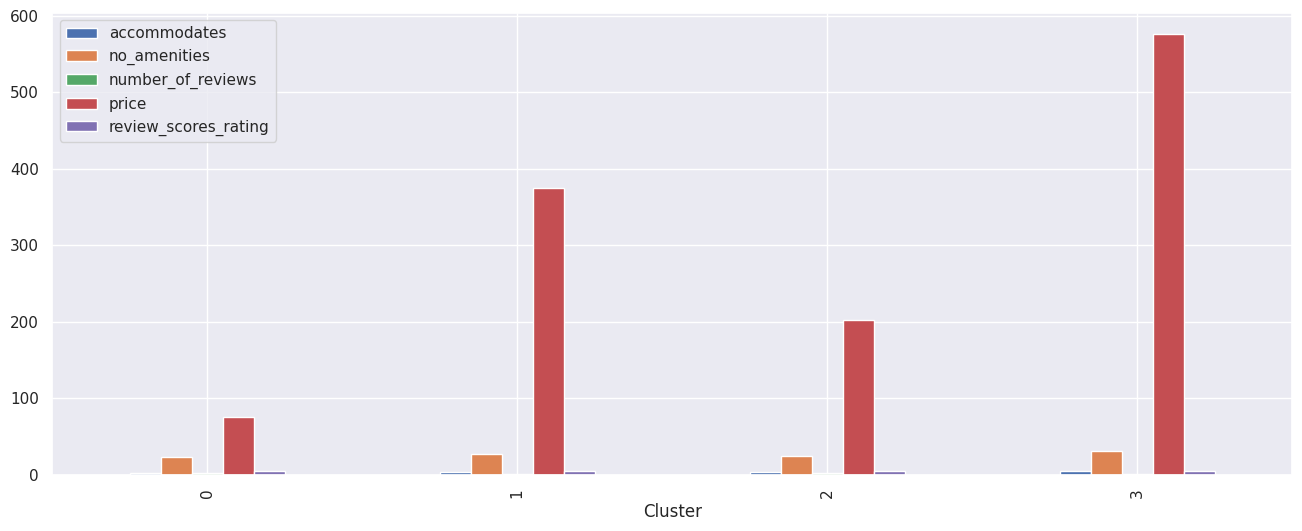

In [136]:
# Average Behaviour of each Cluster
cluster_data = pd.DataFrame(kmeans_labeled.groupby(by = "Cluster").mean())
cluster_data.plot.bar(figsize = (16,6))
     

<Axes: >

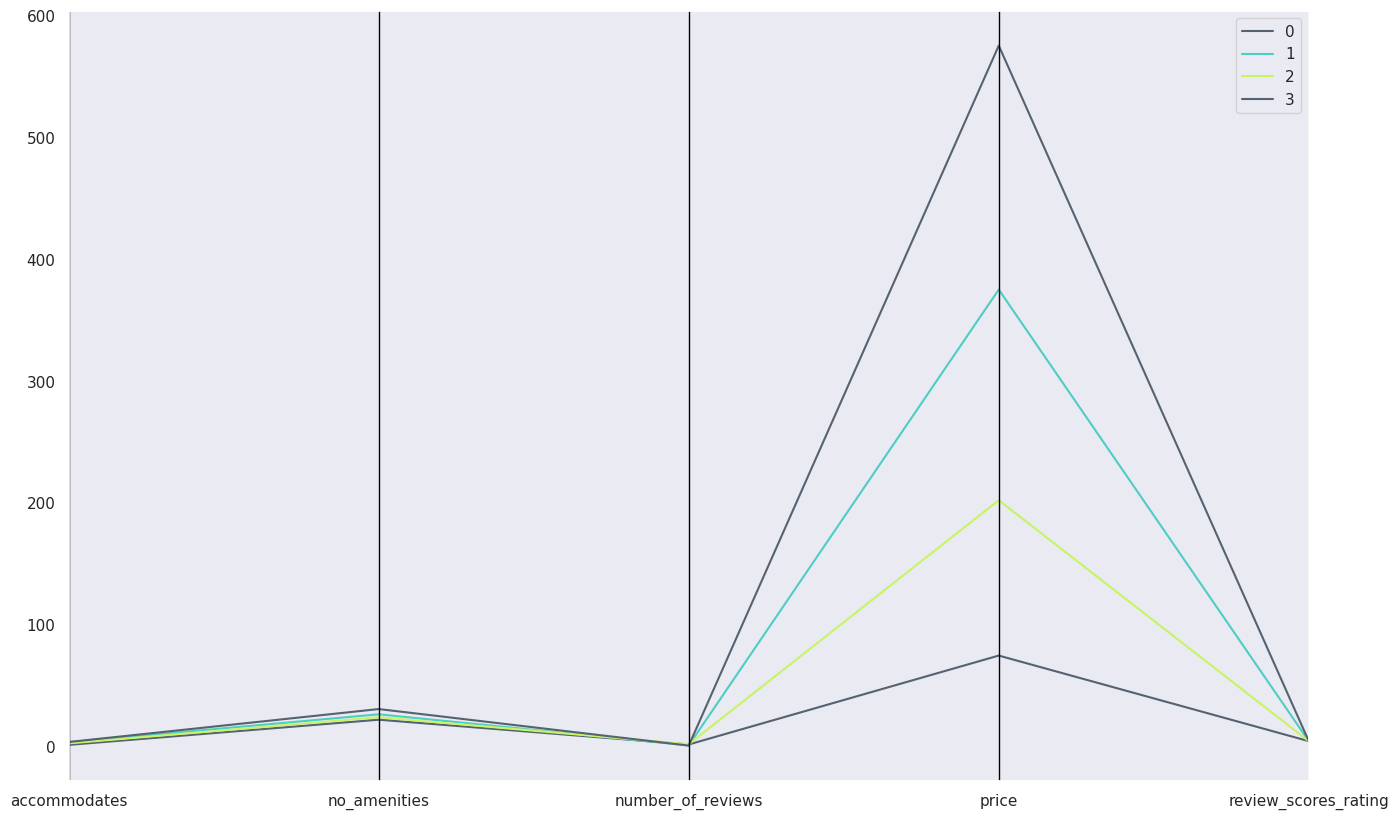

In [137]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=kmeansDF.columns)
centroids['Cluster'] = centroids.index

f, axes = plt.subplots(1, 1, figsize=(16,10))
pd.plotting.parallel_coordinates(centroids, 'Cluster', color=('#556270', '#4ECDC4', '#C7F464'))

---

>## 2. Random Forest

In [138]:
priceDF = airDF["price"]
priceDF.head(n=5)

0     81
1     81
2     52
3     49
4    175
Name: price, dtype: int32

In [144]:
# Import essential models and functions from sklearn (code from Lab 6)
from sklearn.model_selection import train_test_split
# Import RandomForestClassifier model from Scikit-Learn (Lab 6 code)
from sklearn.ensemble import RandomForestClassifier

# Extract Response and Predictors
y = pd.DataFrame(priceDF) #Response
#X = pd.DataFrame(airbnbData_ohe) #Predictor
X = airDF[["accommodates","no_amenities","number_of_reviews"]].copy() #Predictor
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [145]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.price.ravel())

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

In [ ]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(creditData_ohe_up['Rating'])
X = pd.DataFrame(creditData_ohe_up.drop('Rating', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 400,   # found using GridSearchCV
                                 max_depth = 10)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.Rating.ravel())

In [ ]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})